# Data_preparation

### import all relevant libraries



In [13]:
# importing all relevant libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

# Define read functions


In [14]:
import pandas as pd
from haversine import haversine, Unit

# define readin functions
def trip_data_readin(city):
    trip_data = pd.read_csv("../Project_Data/Trip_Data/" + city + ".csv", encoding="ISO-8859-1")
    trip_data = trip_data_data_prep(trip_data)
    trip_data = merge_trip_data_with_weather_data(trip_data, city)
    return trip_data


def trip_data_data_prep(trip_data):
    trip_data["datetime_start"] = pd.to_datetime(trip_data['day'] + ' ' + trip_data['time'])
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_end"] = trip_data["datetime_start"] + trip_data["trip_duration"]
    trip_data["weekday"] = pd.to_datetime(trip_data["datetime_start"]).dt.weekday
    trip_data["month"] = trip_data["datetime_start"].dt.month
    trip_data["hour"] = trip_data["datetime_start"].dt.hour

    trip_data = distance_between_coordinates(trip_data)
    return trip_data


def distance_between_coordinates(trip_data):
    trip_data["distance"] = trip_data.apply(
        lambda row: haversine((row["orig_lat"], row["orig_lng"]), (row["dest_lat"], row["dest_lng"]), Unit.KILOMETERS),
        axis=1)
    return trip_data


def merge_trip_data_with_weather_data(trip_data, city):
    trip_data.set_index(pd.DatetimeIndex(trip_data["datetime_start"]), inplace=True)
    weather = read_DWD_data(city)
    trip_data["rounded_time_hourly"] = trip_data["datetime_start"].dt.round("H")
    combined = pd.merge(trip_data, weather, on="rounded_time_hourly", how='left')
    combined["wind"] = combined['wind'].fillna(method="ffill")
    combined["rain"] = combined['rain'].fillna(method="ffill")
    combined["temp"] = combined['temp'].fillna(method="ffill")
    return combined


def read_DWD_data(city):
    temp_data = pd.read_csv("../Project_Data/Weather_Data/" + city + "/" + "data_TT_TU_MN009.csv", encoding="ISO-8859-1")
    temp_data = temp_data.rename(columns={"Zeitstempel": "rounded_time_hourly"})
    temp_data.set_index((pd.to_datetime(temp_data['rounded_time_hourly'].astype(str), format='%Y%m%d%H%M')),
                        inplace=True)
    temp_data = temp_data.drop(
        ['Produkt_Code', 'SDO_ID', 'SDO_ID', 'Qualitaet_Niveau', 'Qualitaet_Byte', 'rounded_time_hourly'], axis=1)
    temp_data.columns = ['temp']

    wind_data = pd.read_csv("../Project_Data/Weather_Data/" + city + "/" + "data_F_MN003.csv", encoding="ISO-8859-1")
    wind_data = wind_data.rename(columns={"Zeitstempel": "rounded_time_hourly"})
    wind_data.set_index((pd.to_datetime(wind_data['rounded_time_hourly'].astype(str), format='%Y%m%d%H%M')),
                        inplace=True)
    wind_data = wind_data.drop(
        ['Produkt_Code', 'SDO_ID', 'SDO_ID', 'Qualitaet_Niveau', 'Qualitaet_Byte', 'rounded_time_hourly'], axis=1)
    wind_data.columns = ['wind']

    rain_data = pd.read_csv("../Project_Data/Weather_Data/" + city + "/" + "data_R1_MN008.csv", encoding="ISO-8859-1")
    rain_data = rain_data.rename(columns={"Zeitstempel": "rounded_time_hourly"})
    rain_data.set_index((pd.to_datetime(rain_data['rounded_time_hourly'].astype(str), format='%Y%m%d%H%M')),
                        inplace=True)
    rain_data = rain_data.drop(
        ['Produkt_Code', 'SDO_ID', 'SDO_ID', 'Qualitaet_Niveau', 'Qualitaet_Byte', 'rounded_time_hourly'], axis=1)
    rain_data.columns = ['rain']

    weather = pd.merge(temp_data, wind_data, on="rounded_time_hourly", how='left')
    weather = pd.merge(weather, rain_data, on="rounded_time_hourly", how='left')
    return weather


# create combined dataSet
def export(city_name):
    data_set = trip_data_readin(city_name)
    data_set.to_csv("../Project_Data/Combined_Data/" + city_name + ".csv")

def round_to_nearest(x, base=5):
    '''
    Rounds a value to the nearest base step, per default base=5
    :param x: the value to round
    :param base: the number, to which is rounded (e.g. 12 is rounded down to 10, 13 is rounded up to 15)
    :return: an integer whose value is the rounded value of the param value
    '''
    return int(base * round(float(x)/base))

## Set styles

In [15]:
# set seaborn styles
sns.set()
sns.set_style("whitegrid")
sns.set_palette("pastel")

# set pandas display styles
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 2000)

## Define plot generating function for a single city
Generates plots of revenue per hour, summed, and revenue per hour, on average,
for a given city and time frame. For each city 4 plots are generated, 2 of those scatter plots
and 2 line plots, plotting both KPI's, respectively.


In [20]:
#
# TASK: CALCULATE REVENUE PER BIKE FOR BOTH CITIES BREMEN AND DÜSSELDORF
#       CALCULATE KPI HOURLY, VISUALIZE OVER TIME (DAY, WEEK, MONTH)
#

def generate_plot_revenue_per_hour_for_city(city, start_date, end_date, time_interval):
    '''
    Generates plots of revenue per hour, summed, and revenue per hour, on average,
    for a given city and time frame. For each city 4 plots are generated, 2 of those scatter plots
    and 2 line plots, plotting both KPI's, respectively.

    :param city: a city in string format, e.g. "Bremen" or "Duesseldorf"
    :param start_date: an iso format time string, e.g. "2019-03-28 12:00:00"
    :param end_date: an iso format time string, e.g. "2019-03-31 12:00:00"
    :param time_interval: a string defining the length of time interval (used for plot titles)
    '''

    # sorting and key stats of data
    trip_data_br = trip_data_readin(city)
    trip_data_br_sorted = trip_data_br.sort_values(by=['day'], axis=0)

    # count trip duration intervals for each trip, i.e. how much revenue each trip generated,
    # by setting the revenue to 1 plus the number of 30-minute durations fitting into the trip duration
    trip_data_br_sorted["revenue_per_trip"] = trip_data_br_sorted["trip_duration"].apply(
        lambda x: float((math.floor(x / pd.Timedelta(minutes=30))) + 1))
    print("Added Revenue per trip: \n\n", trip_data_br_sorted.head(10))

    # SET TIME WINDOW FOR HOURLY GROUPING OF VALUES
    startDate = datetime.fromisoformat(start_date)
    endDate = datetime.fromisoformat(end_date)

    # select rows in the given time window
    mask = (trip_data_br_sorted["datetime_start"] > startDate) & (trip_data_br_sorted["datetime_start"] <= endDate)
    trip_data_br_sorted_time_framed = trip_data_br_sorted.loc[mask]

    # Group data in the given time window by hours and aggregate the revenue per trip:
    # as sum over all rented bikes in a specific hour, and as average over all rented bikes in a specific hour
    times = pd.DatetimeIndex(trip_data_br_sorted_time_framed.datetime_start)
    groupedByHours = trip_data_br_sorted_time_framed.groupby([times.month, times.day, times.hour])[
        "revenue_per_trip"].agg(num_of_trips_per_hour="count", revenue_per_hour_sum="sum", revenue_per_hour_avg="mean")

    # reset index to get time labels as column labels
    groupedByHours.index.rename(["month", "day", "hour"], inplace=True)
    groupedByHours.reset_index(inplace=True)

    # generate date column for plot labelling
    groupedByHours["date"] = "2019-" + groupedByHours["month"].astype(str) + "-" +  groupedByHours["day"].astype(str) + " " + \
                             groupedByHours["hour"].astype(str) + ":00:00"

    # generate datetime column for checking of weekdays
    groupedByHours["datetime"] = [pd.to_datetime(d) for d in groupedByHours.date]

    # check, if date is weekday (.weekday() returns 0 for a monday, and 6 for a sunday)
    groupedByHours["is_weekday"] = [dt.weekday() <= 4 for dt in groupedByHours.datetime]

    # GROUPING AND VISUALIZATION
    print("Grouped by hours: \n\n", groupedByHours.head(20))
    print(groupedByHours.info())

    # create figure and axes
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    plt.rcParams["font.size"] = 2

    # generate scatter plots
    plot1 = sns.scatterplot(ax=ax1, data=groupedByHours, x="date", y="revenue_per_hour_sum", hue="is_weekday", ci=None)
    plot2 = sns.scatterplot(ax=ax2, data=groupedByHours, x="date", y="revenue_per_hour_avg", hue="is_weekday", ci=None)

    # set tick and label options
    ax1.tick_params(labelrotation=90)
    ax2.tick_params(labelrotation=90)
    plt.setp(plot1.axes.get_xticklabels()[::2], visible=False)
    plt.setp(plot2.axes.get_xticklabels()[::2], visible=False)
    ax1.set_title(f"Revenue/hour (sum) for {city} from {startDate} to {endDate} ({time_interval})")
    ax2.set_title(f"Revenue/hour (avg) for {city} from {startDate} to {endDate} ({time_interval})")

    fig1.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25)

    # create figure and axes
    fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    # generate line plots
    plot3 = sns.lineplot(ax=ax3, data=groupedByHours, x="date", y="revenue_per_hour_sum", hue="is_weekday", ci=None)
    plot4 = sns.lineplot(ax=ax4, data=groupedByHours, x="date", y="revenue_per_hour_avg", hue="is_weekday", ci=None)

    # set tick and label options
    ax3.tick_params(labelrotation=90)
    ax4.tick_params(labelrotation=90)
    plt.setp(plot3.axes.get_xticklabels()[::2], visible=False)
    plt.setp(plot4.axes.get_xticklabels()[::2], visible=False)
    ax3.set_title(f"Revenue/hour (sum) for {city} from {startDate} to {endDate} ({time_interval})")
    ax4.set_title(f"Revenue/hour (avg) for {city} from {startDate} to {endDate} ({time_interval})")

    fig2.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25)

## Generating plots

### Day

Added Revenue per trip: 

               day      time  b_number    city trip_duration   orig_lat  orig_lng   dest_lat  dest_lng      datetime_start        datetime_end  weekday  month  hour  distance rounded_time_hourly  temp  wind  rain  revenue_per_trip
26294  2019-02-01  18:15:00     20728  bremen      00:15:00  53.064904  8.879091  53.079818  8.835600 2019-02-01 18:15:00 2019-02-01 18:30:00        4      2    18  3.345437 2019-02-01 18:00:00   0.5   3.3   0.0               1.0
33161  2019-02-01  23:03:00     20799  bremen      00:11:00  53.072819  8.827893  53.080142  8.827389 2019-02-01 23:03:00 2019-02-01 23:14:00        4      2    23  0.815013 2019-02-01 23:00:00  -1.7   2.9   0.0               1.0
33160  2019-02-01  17:25:00     20799  bremen      00:07:00  53.074592  8.810182  53.072729  8.827655 2019-02-01 17:25:00 2019-02-01 17:32:00        4      2    17  1.185499 2019-02-01 17:00:00   1.1   3.0   0.0               1.0
25746  2019-02-01  16:30:00     20724  bremen      00

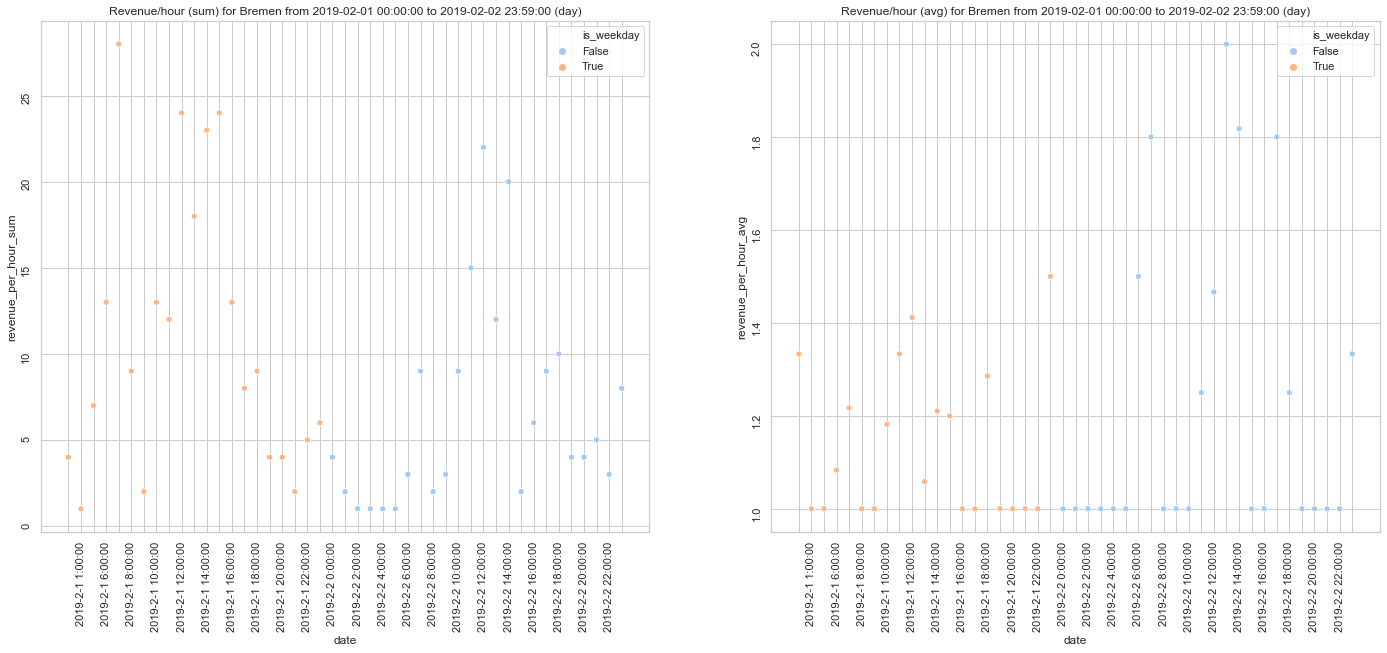

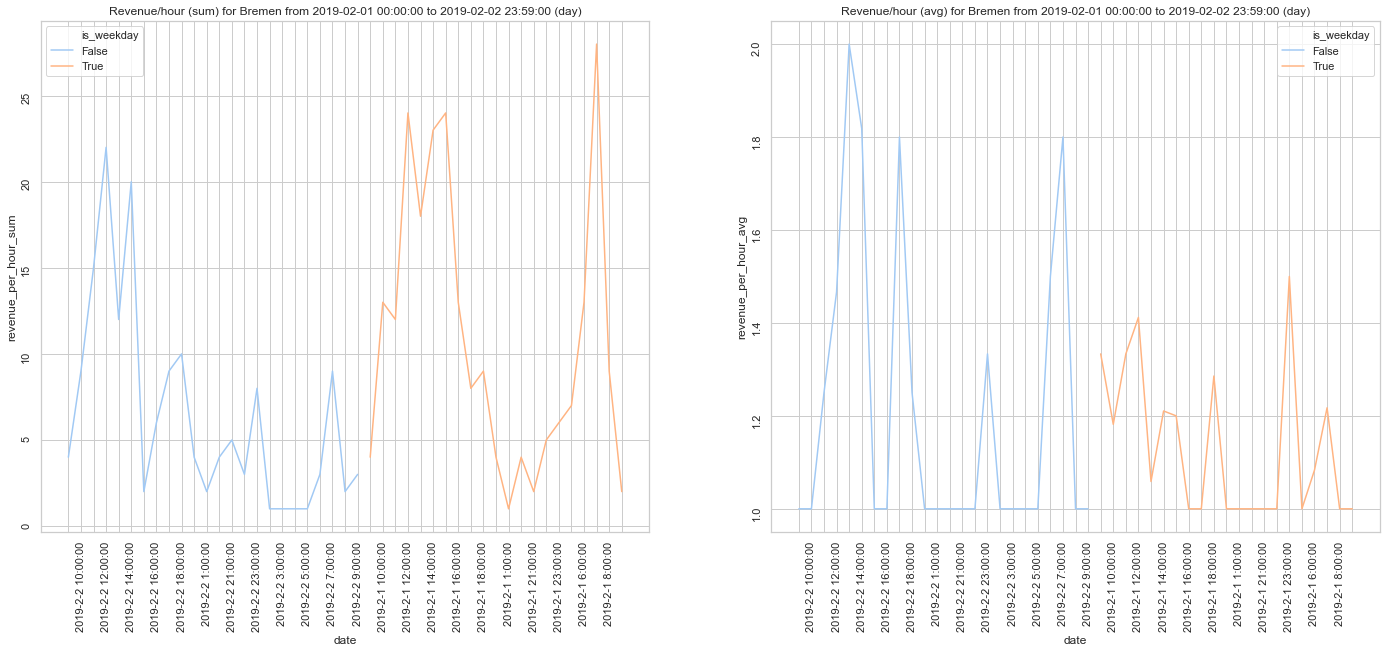

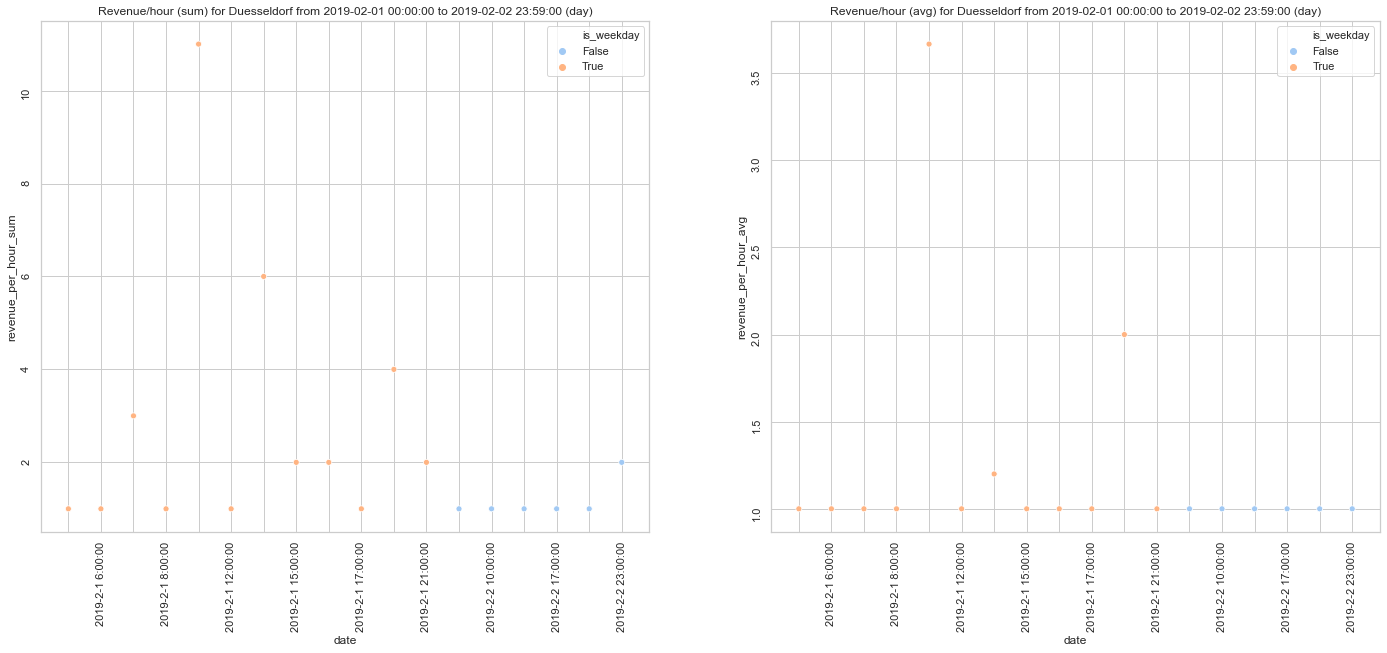

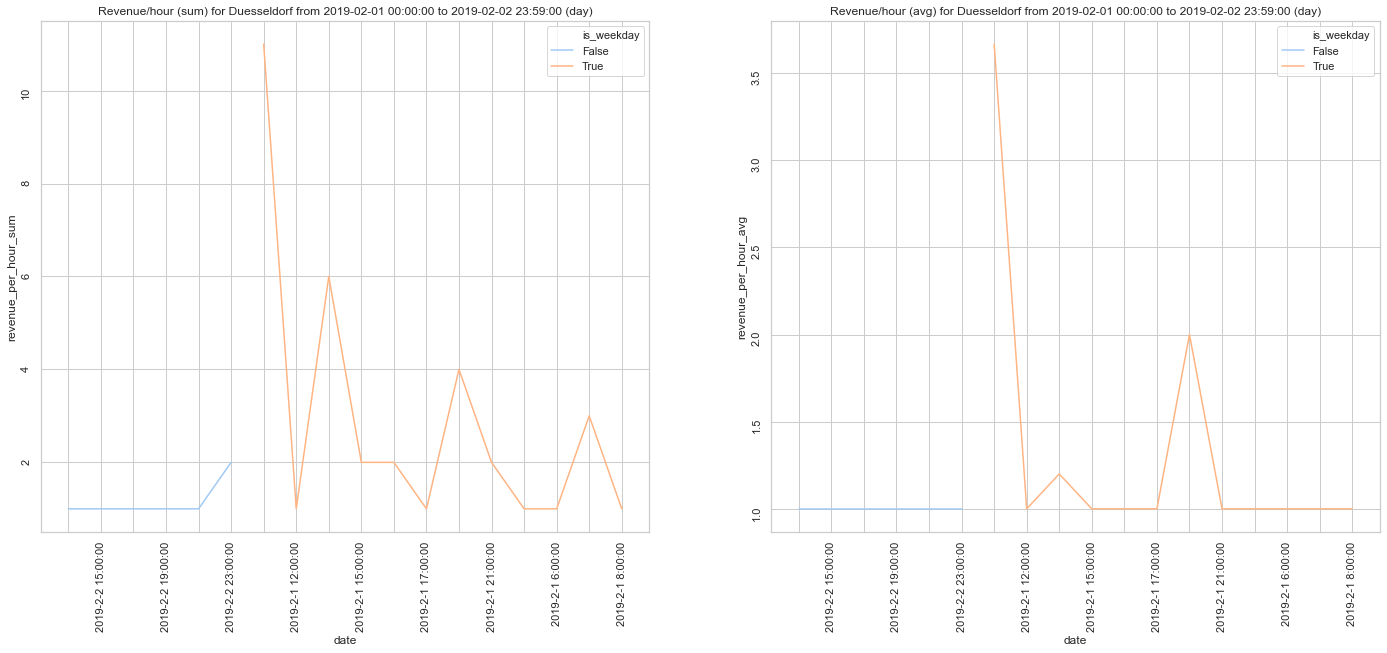

In [21]:
# generate plots for both cities
cities = ["Bremen", "Duesseldorf"]
for city in cities:
    generate_plot_revenue_per_hour_for_city(city, "2019-02-01 00:00:00", "2019-02-02 23:59:00", "day")

plt.legend()
plt.show()

### Week

Added Revenue per trip: 

               day      time  b_number    city trip_duration   orig_lat  orig_lng   dest_lat  dest_lng      datetime_start        datetime_end  weekday  month  hour  distance rounded_time_hourly  temp  wind  rain  revenue_per_trip
26294  2019-02-01  18:15:00     20728  bremen      00:15:00  53.064904  8.879091  53.079818  8.835600 2019-02-01 18:15:00 2019-02-01 18:30:00        4      2    18  3.345437 2019-02-01 18:00:00   0.5   3.3   0.0               1.0
33161  2019-02-01  23:03:00     20799  bremen      00:11:00  53.072819  8.827893  53.080142  8.827389 2019-02-01 23:03:00 2019-02-01 23:14:00        4      2    23  0.815013 2019-02-01 23:00:00  -1.7   2.9   0.0               1.0
33160  2019-02-01  17:25:00     20799  bremen      00:07:00  53.074592  8.810182  53.072729  8.827655 2019-02-01 17:25:00 2019-02-01 17:32:00        4      2    17  1.185499 2019-02-01 17:00:00   1.1   3.0   0.0               1.0
25746  2019-02-01  16:30:00     20724  bremen      00

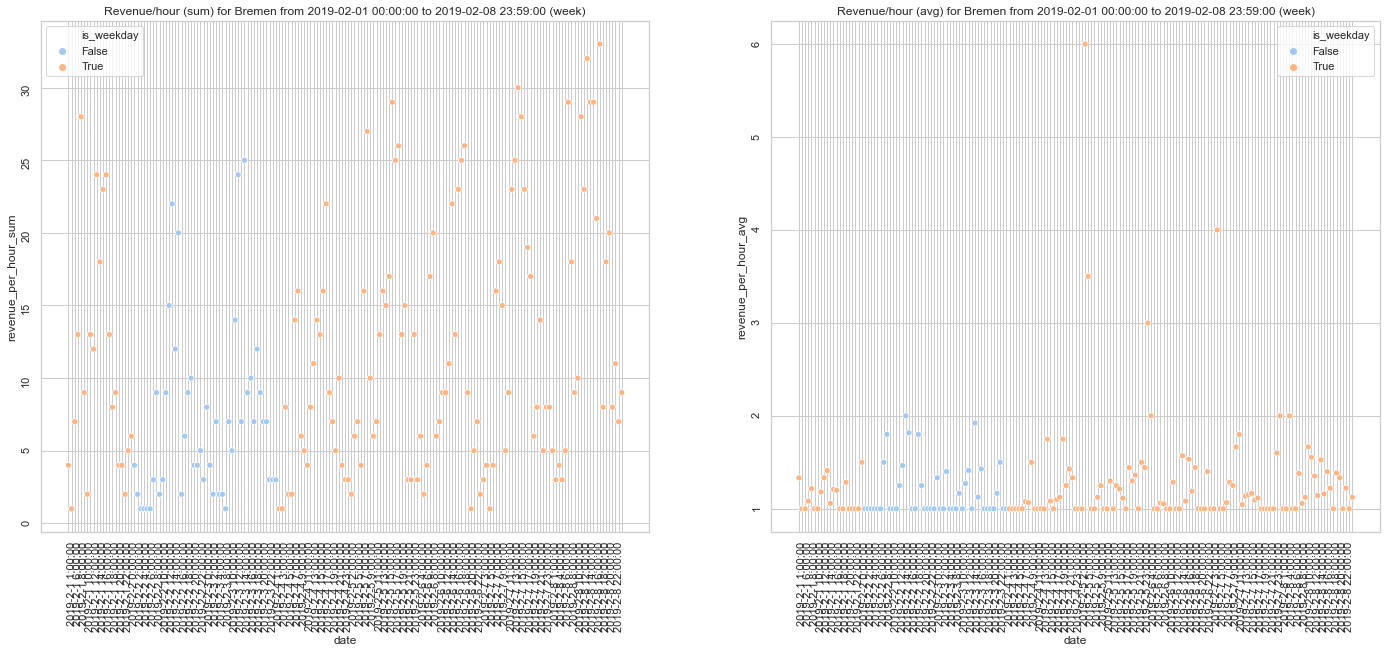

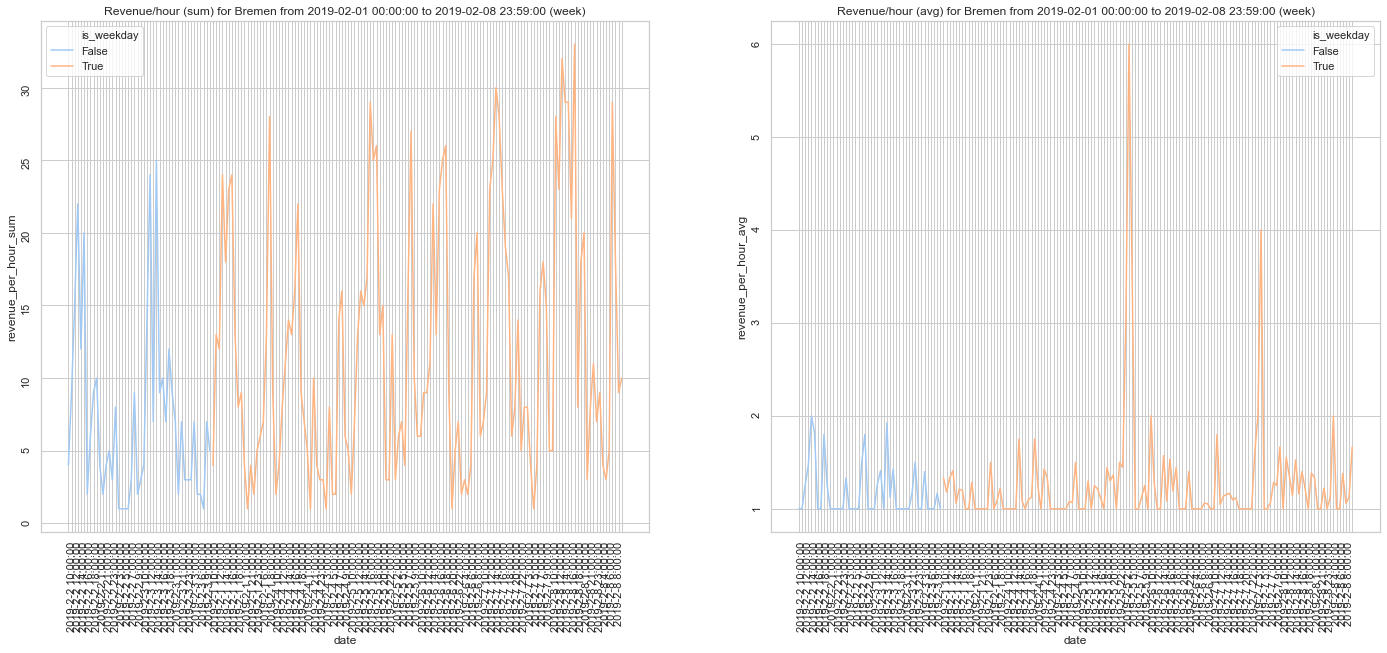

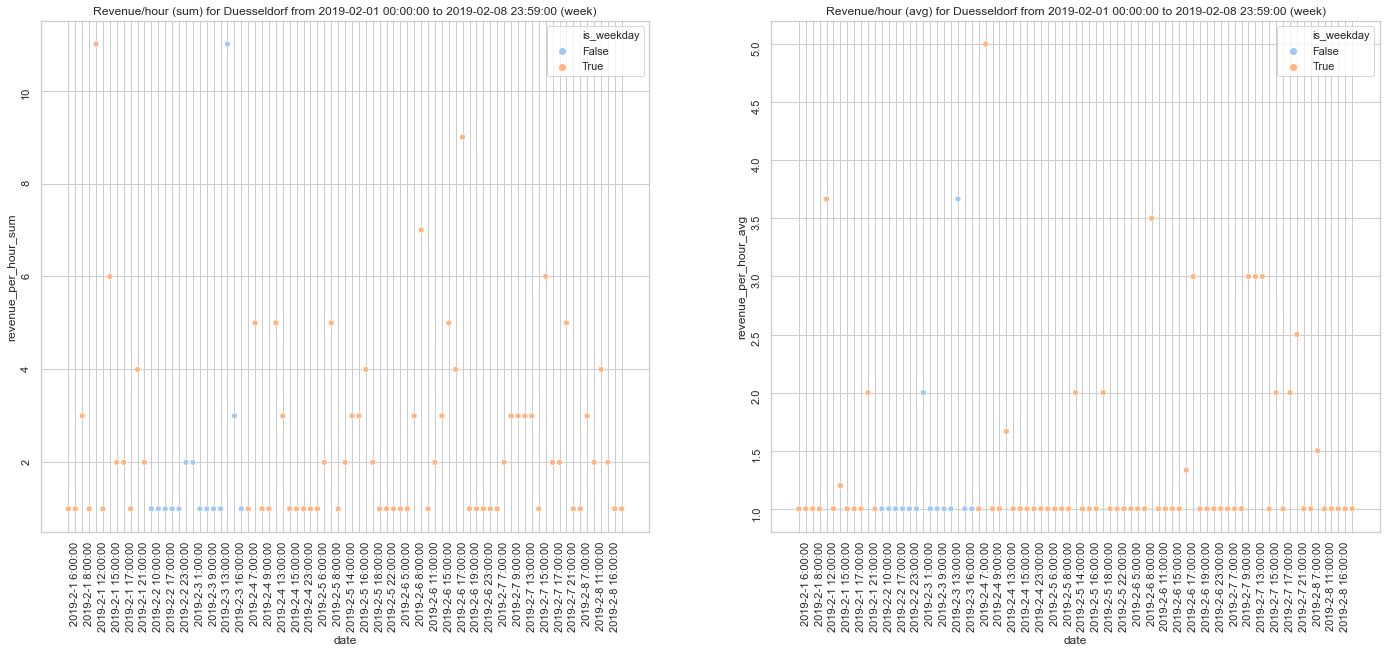

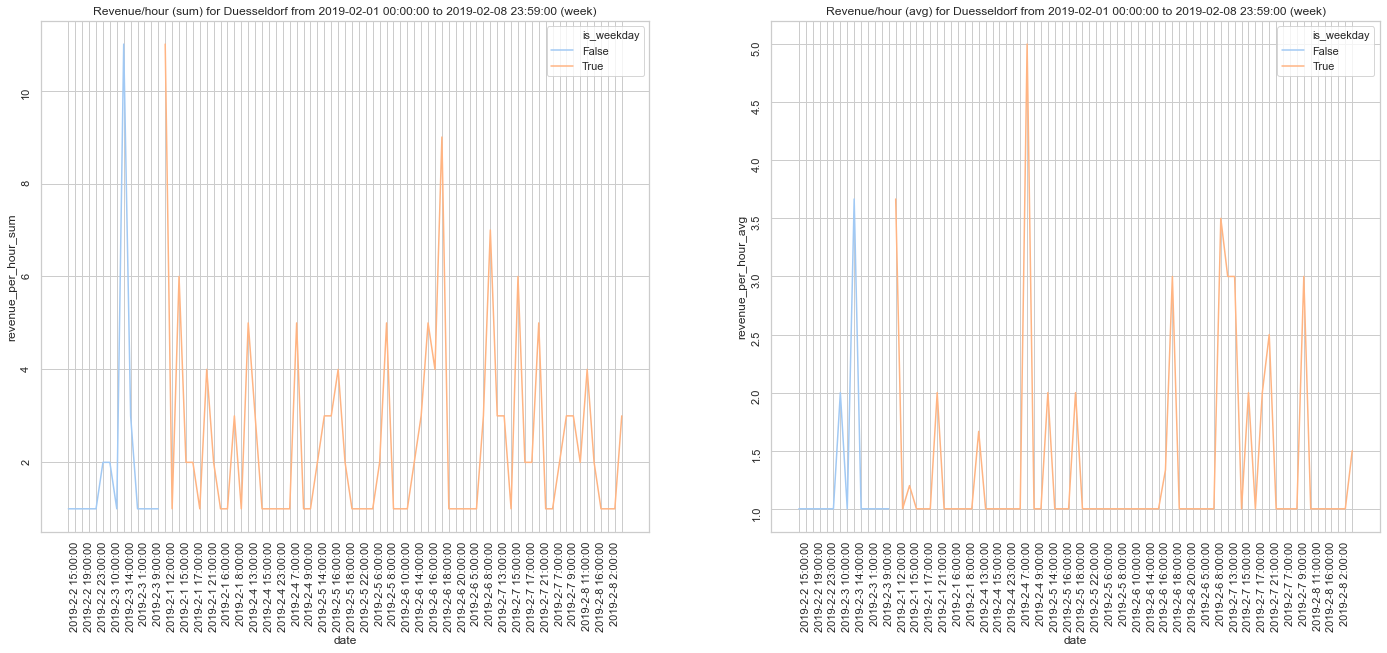

In [22]:
# generate plots for both cities
cities = ["Bremen", "Duesseldorf"]
for city in cities:
    generate_plot_revenue_per_hour_for_city(city, "2019-02-01 00:00:00", "2019-02-08 23:59:00", "week")

plt.legend()
plt.show()

In [1]:
### Month

In [ ]:
# generate plots for both cities
cities = ["Bremen", "Duesseldorf"]
for city in cities:
    generate_plot_revenue_per_hour_for_city(city, "2019-02-01 00:00:00", "2019-02-28 23:59:00", "month")

plt.legend()
plt.show()